In [87]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from math import sin, cos, sqrt, atan2, radians
import datetime

# Загружаем данные

In [88]:
train = pd.read_csv('train.csv')
train.head()

,cancel_time,driver_found,due,f_class,lat,lon,s_class,t_class,burned
0,55,False,2014-01-01 00:09:32.000,econom,55.750130,37.823242,NaN,NaN,True
1,-1,True,2014-01-01 00:09:32.000,econom,55.750130,37.823242,NaN,NaN,False
2,-1,True,2014-01-01 00:10:00.000,econom,55.651582,37.340891,NaN,NaN,False
3,-1,True,2014-01-01 00:10:00.000,econom,55.633404,37.797595,NaN,NaN,False
4,-1,True,2014-01-01 00:10:00.000,econom,55.770330,37.519917,NaN,NaN,False


In [89]:
test = pd.read_csv('test.csv')
test.head()

,due,f_class,lat,lon,s_class,t_class
1449959,2014-03-15 12:40:00.000,econom,55.612065,37.760539,NaN,NaN
1449941,2014-03-15 12:40:00.000,econom,55.784369,37.672244,business,NaN
1449961,2014-03-15 12:40:00.000,econom,55.716803,37.422776,NaN,NaN
1449960,2014-03-15 12:40:00.000,econom,55.791430,37.472090,NaN,NaN
1449978,2014-03-15 12:40:00.000,econom,59.845695,30.371014,NaN,NaN


In [90]:
train=train.drop(['cancel_time','driver_found'],axis=1)
train.head()

,due,f_class,lat,lon,s_class,t_class,burned
0,2014-01-01 00:09:32.000,econom,55.750130,37.823242,NaN,NaN,True
1,2014-01-01 00:09:32.000,econom,55.750130,37.823242,NaN,NaN,False
2,2014-01-01 00:10:00.000,econom,55.651582,37.340891,NaN,NaN,False
3,2014-01-01 00:10:00.000,econom,55.633404,37.797595,NaN,NaN,False
4,2014-01-01 00:10:00.000,econom,55.770330,37.519917,NaN,NaN,False


# Готовим фичи и фитим модель

In [91]:
train['burned']=np.where(train['burned']==True,1,0)
y=train[['burned']]

In [92]:
train['burned'].value_counts()

0    1212757
1     237243
Name: burned, dtype: int64

**Близость аэропортов и вокзалов:**

Коориданты аэропортов:

In [93]:
#Домодедово
DMElat = 55.4086110
DMElon = 37.9061110
#Шереметьвево
SVOlat = 55.9727780
SVOlon = 37.4147220
#Внуково
VKOlat = 55.6031500
VKOlon = 37.2921000
#Пулково
PLlat = 59.7998772
PLlon = 30.2733421

Координаты вокзалов:

In [94]:
#Белорусский
BELlat = 55.7768974
BELlon = 37.5813255
#Ленинградский 
LENlat = 55.7765312
LENlon = 37.6551781
#Ярославский
YRlat = 55.7770042
YRlon = 37.6571884
#Казанский
KZlat = 55.7737923
KZlon = 37.6570778
#Киевский
KVlat = 55.7432632
KVlon = 37.5665741
#Курский
KRlat = 55.7576218 
KRlon = 37.6607666
#Павелецкий 
PVLlat = 55.7298279
PVLlon = 37.6389351
#Рижский
RJlat = 55.792609
RJlon = 37.632615
#Савеловский
SVLlat = 55.793738
SVLlon = 37.587865
#Витебский 
VTBlat = 59.9199219
VTBlon = 30.3288956
#Ладожский
LDlat = 59.9317513
LDlon = 30.4410629
#Московский
MSKlat = 59.929996 
MSKlon = 30.362145
#Финский
FINlat = 59.955641
FINlon = 30.356502
#Балтийский
BLlat = 59.907115
BLlon = 30.298882

Столько составляет 1 км и 300 м в наших условных единицах:

In [95]:
a = 55.609655
b = 37.303817
km =((a - VKOlat)**2 + (b - VKOlon)**2)**0.5
m = km*400/1000
print(km)#1 км
print(m)#300 м 

0.013401608634789548
0.005360643453915819


Расстояние от точки вызыва такси до аэропорта:

In [96]:
train['DistanceToDME'] = ((train['lat'] - DMElat)**2 + (train['lon'] - DMElon)**2)**0.5
train['DistanceToSVO'] =((train['lat'] - SVOlat)**2 + (train['lon'] - SVOlon)**2)**0.5
train['DistanceToVKO'] =((train['lat'] - VKOlat)**2 + (train['lon'] - VKOlon)**2)**0.5
train['DistanceToPL'] = ((train['lat'] - PLlat)**2 + (train['lon'] - PLlon)**2)**0.5

Близость к аэропортам:

In [97]:
train['Airports'] = np.where(
    (train['DistanceToDME']<=km) | \
    (train['DistanceToSVO']<=km) | \
    (train['DistanceToVKO']<=km) | \
    (train['DistanceToPL']<=km),
    1,0)

Расстояние от точки вызыва такси до вокзала:

In [98]:
train['DistanceToBEL'] = ((train['lat'] - BELlat)**2 + (train['lon'] - BELlon)**2)**0.5
train['DistanceToLEN'] = ((train['lat'] - LENlat)**2 + (train['lon'] - LENlon)**2)**0.5
train['DistanceToYR'] = ((train['lat'] - YRlat)**2 + (train['lon'] - YRlon)**2)**0.5
train['DistanceToKZ'] = ((train['lat'] - KZlat)**2 + (train['lon'] - KZlon)**2)**0.5
train['DistanceToKV'] = ((train['lat'] - KVlat)**2 + (train['lon'] - KVlon)**2)**0.5
train['DistanceToKR'] = ((train['lat'] - KRlat)**2 + (train['lon'] - KRlon)**2)**0.5
train['DistanceToPVL'] = ((train['lat'] - PVLlat)**2 + (train['lon'] - PVLlon)**2)**0.5
train['DistanceToRJ'] = ((train['lat'] - RJlat)**2 + (train['lon'] - RJlon)**2)**0.5
train['DistanceToSVL'] = ((train['lat'] - SVLlat)**2 + (train['lon'] - SVLlon)**2)**0.5
train['DistanceToVTB'] = ((train['lat'] - VTBlat)**2 + (train['lon'] - VTBlon)**2)**0.5
train['DistanceToLD'] = ((train['lat'] - LDlat)**2 + (train['lon'] - LDlon)**2)**0.5
train['DistanceToMSK'] = ((train['lat'] - MSKlat)**2 + (train['lon'] - MSKlon)**2)**0.5
train['DistanceToFIN'] = ((train['lat'] - FINlat)**2 + (train['lon'] - FINlon)**2)**0.5
train['DistanceToBL'] = ((train['lat'] - BLlat)**2 + (train['lon'] - BLlon)**2)**0.5

Близость к вокзалам:

In [99]:
train['Railway_station'] = np.where((
    train['DistanceToBEL']<=m) | \
    (train['DistanceToLEN']<=m) | \
    (train['DistanceToYR']<=m) | \
    (train['DistanceToKZ']<=m) | \
    (train['DistanceToKV']<=m) | \
    (train['DistanceToKR']<=m) | \
    (train['DistanceToPVL']<=m) | \
    (train['DistanceToRJ']<=m) | \
    (train['DistanceToSVL']<=m) | \
    (train['DistanceToBL']<=m) | \
    (train['DistanceToFIN']<=m) | \
    (train['DistanceToMSK']<=m) | \
    (train['DistanceToLD']<=m) | \
    (train['DistanceToVTB']<=m), \
    1,0)


Местоположение машины:

In [100]:
from sklearn.preprocessing import StandardScaler
ss=StandardScaler()

train[['lat','lon']]=ss.fit_transform(train[['lat','lon']])

Distance=train[train.columns[pd.Series(train.columns).str.startswith('Distance')]]
train[train.columns[pd.Series(train.columns).str.startswith('Distance')]]=ss.fit_transform(Distance)

train['cossin']=np.cos(train['lon'])*np.sin(train['lat'])
train['sincos']=np.sin(train['lon'])*np.cos(train['lat'])
train['cos']=np.cos(train['lat'])

In [119]:
cols1=[
 #'f_class',
 #'lat',
 #'lon',
 #'s_class',
 #'t_class']
 #'burned',
 'DistanceToDME',
 'DistanceToSVO',
 'DistanceToVKO',
 'DistanceToPL',
 'Airports',
 'DistanceToBEL',
 'DistanceToLEN',
 'DistanceToYR',
 'DistanceToKZ',
 'DistanceToKV',
 'DistanceToKR',
 'DistanceToPVL',
 'DistanceToRJ',
 'DistanceToSVL',
 'DistanceToVTB',
 'DistanceToLD',
 'DistanceToMSK',
 'DistanceToFIN',
 'DistanceToBL',
 'Railway_station']
 #'cossin',
 #'sincos',
 #'cos']
Xc1=X[cols1]
Xc1.columns.tolist()

['DistanceToDME',
 'DistanceToSVO',
 'DistanceToVKO',
 'DistanceToPL',
 'Airports',
 'DistanceToBEL',
 'DistanceToLEN',
 'DistanceToYR',
 'DistanceToKZ',
 'DistanceToKV',
 'DistanceToKR',
 'DistanceToPVL',
 'DistanceToRJ',
 'DistanceToSVL',
 'DistanceToVTB',
 'DistanceToLD',
 'DistanceToMSK',
 'DistanceToFIN',
 'DistanceToBL',
 'Railway_station']

In [120]:
from catboost import CatBoostClassifier
cat=CatBoostClassifier()
cat.fit(X=Xc1,y=y)

0:	learn: 0.6248235	total: 379ms	remaining: 6m 18s
1:	learn: 0.5751856	total: 767ms	remaining: 6m 22s
2:	learn: 0.5389429	total: 1.15s	remaining: 6m 20s
3:	learn: 0.5127087	total: 1.52s	remaining: 6m 19s
4:	learn: 0.4934935	total: 1.98s	remaining: 6m 34s
5:	learn: 0.4795363	total: 2.4s	remaining: 6m 37s
6:	learn: 0.4691674	total: 2.88s	remaining: 6m 49s
7:	learn: 0.4615038	total: 3.26s	remaining: 6m 44s
8:	learn: 0.4558340	total: 3.67s	remaining: 6m 43s
9:	learn: 0.4516205	total: 4.01s	remaining: 6m 36s
10:	learn: 0.4485256	total: 4.34s	remaining: 6m 30s
11:	learn: 0.4462188	total: 4.76s	remaining: 6m 31s
12:	learn: 0.4444170	total: 5.12s	remaining: 6m 28s
13:	learn: 0.4431187	total: 5.52s	remaining: 6m 28s
14:	learn: 0.4421146	total: 5.91s	remaining: 6m 27s
15:	learn: 0.4413249	total: 6.27s	remaining: 6m 25s
16:	learn: 0.4407298	total: 6.67s	remaining: 6m 25s
17:	learn: 0.4403584	total: 6.96s	remaining: 6m 19s
18:	learn: 0.4399892	total: 7.31s	remaining: 6m 17s
19:	learn: 0.4396442	to

158:	learn: 0.4359766	total: 1m 1s	remaining: 5m 25s
159:	learn: 0.4359570	total: 1m 1s	remaining: 5m 24s
160:	learn: 0.4359502	total: 1m 2s	remaining: 5m 24s
161:	learn: 0.4359396	total: 1m 2s	remaining: 5m 24s
162:	learn: 0.4359233	total: 1m 3s	remaining: 5m 23s
163:	learn: 0.4359073	total: 1m 3s	remaining: 5m 23s
164:	learn: 0.4358923	total: 1m 3s	remaining: 5m 23s
165:	learn: 0.4358742	total: 1m 4s	remaining: 5m 22s
166:	learn: 0.4358606	total: 1m 4s	remaining: 5m 22s
167:	learn: 0.4358423	total: 1m 5s	remaining: 5m 22s
168:	learn: 0.4358371	total: 1m 5s	remaining: 5m 21s
169:	learn: 0.4358215	total: 1m 5s	remaining: 5m 21s
170:	learn: 0.4358117	total: 1m 6s	remaining: 5m 20s
171:	learn: 0.4357929	total: 1m 6s	remaining: 5m 20s
172:	learn: 0.4357805	total: 1m 6s	remaining: 5m 19s
173:	learn: 0.4357678	total: 1m 7s	remaining: 5m 19s
174:	learn: 0.4357440	total: 1m 7s	remaining: 5m 19s
175:	learn: 0.4357359	total: 1m 8s	remaining: 5m 18s
176:	learn: 0.4357244	total: 1m 8s	remaining: 

311:	learn: 0.4342661	total: 1m 59s	remaining: 4m 24s
312:	learn: 0.4342545	total: 2m	remaining: 4m 23s
313:	learn: 0.4342486	total: 2m	remaining: 4m 23s
314:	learn: 0.4342347	total: 2m 1s	remaining: 4m 23s
315:	learn: 0.4342281	total: 2m 1s	remaining: 4m 22s
316:	learn: 0.4342198	total: 2m 1s	remaining: 4m 22s
317:	learn: 0.4342174	total: 2m 2s	remaining: 4m 21s
318:	learn: 0.4342042	total: 2m 2s	remaining: 4m 21s
319:	learn: 0.4341917	total: 2m 2s	remaining: 4m 21s
320:	learn: 0.4341840	total: 2m 3s	remaining: 4m 20s
321:	learn: 0.4341726	total: 2m 3s	remaining: 4m 20s
322:	learn: 0.4341680	total: 2m 4s	remaining: 4m 20s
323:	learn: 0.4341578	total: 2m 4s	remaining: 4m 19s
324:	learn: 0.4341541	total: 2m 4s	remaining: 4m 19s
325:	learn: 0.4341437	total: 2m 5s	remaining: 4m 18s
326:	learn: 0.4341380	total: 2m 5s	remaining: 4m 18s
327:	learn: 0.4341304	total: 2m 5s	remaining: 4m 17s
328:	learn: 0.4341242	total: 2m 6s	remaining: 4m 17s
329:	learn: 0.4341137	total: 2m 6s	remaining: 4m 17


Iteration with suspicious time 77.6 sec ignored in overall statistics.


435:	learn: 0.4332715	total: 2m 47s	remaining: 3m 37s
436:	learn: 0.4332650	total: 2m 48s	remaining: 3m 37s
437:	learn: 0.4332542	total: 2m 48s	remaining: 3m 37s
438:	learn: 0.4332429	total: 2m 50s	remaining: 3m 38s
439:	learn: 0.4332371	total: 2m 51s	remaining: 3m 38s
440:	learn: 0.4332341	total: 2m 51s	remaining: 3m 38s
441:	learn: 0.4332260	total: 2m 52s	remaining: 3m 37s
442:	learn: 0.4332206	total: 2m 52s	remaining: 3m 37s
443:	learn: 0.4332143	total: 2m 53s	remaining: 3m 38s
444:	learn: 0.4332062	total: 2m 54s	remaining: 3m 38s
445:	learn: 0.4332033	total: 2m 55s	remaining: 3m 38s
446:	learn: 0.4331982	total: 2m 55s	remaining: 3m 37s
447:	learn: 0.4331910	total: 2m 56s	remaining: 3m 37s
448:	learn: 0.4331857	total: 2m 56s	remaining: 3m 37s
449:	learn: 0.4331794	total: 2m 57s	remaining: 3m 37s
450:	learn: 0.4331758	total: 2m 57s	remaining: 3m 36s
451:	learn: 0.4331674	total: 2m 58s	remaining: 3m 36s
452:	learn: 0.4331596	total: 2m 58s	remaining: 3m 36s
453:	learn: 0.4331538	total:

589:	learn: 0.4322701	total: 4m 2s	remaining: 2m 49s
590:	learn: 0.4322651	total: 4m 3s	remaining: 2m 48s
591:	learn: 0.4322639	total: 4m 3s	remaining: 2m 48s
592:	learn: 0.4322575	total: 4m 4s	remaining: 2m 47s
593:	learn: 0.4322546	total: 4m 4s	remaining: 2m 47s
594:	learn: 0.4322471	total: 4m 4s	remaining: 2m 46s
595:	learn: 0.4322429	total: 4m 5s	remaining: 2m 46s
596:	learn: 0.4322400	total: 4m 5s	remaining: 2m 46s
597:	learn: 0.4322381	total: 4m 5s	remaining: 2m 45s
598:	learn: 0.4322258	total: 4m 6s	remaining: 2m 45s
599:	learn: 0.4322193	total: 4m 6s	remaining: 2m 44s
600:	learn: 0.4322121	total: 4m 7s	remaining: 2m 44s
601:	learn: 0.4322063	total: 4m 8s	remaining: 2m 44s
602:	learn: 0.4321991	total: 4m 8s	remaining: 2m 43s
603:	learn: 0.4321938	total: 4m 9s	remaining: 2m 43s
604:	learn: 0.4321897	total: 4m 9s	remaining: 2m 43s
605:	learn: 0.4321830	total: 4m 10s	remaining: 2m 42s
606:	learn: 0.4321741	total: 4m 10s	remaining: 2m 42s
607:	learn: 0.4321657	total: 4m 10s	remainin

743:	learn: 0.4313419	total: 5m 12s	remaining: 1m 47s
744:	learn: 0.4313392	total: 5m 12s	remaining: 1m 47s
745:	learn: 0.4313317	total: 5m 13s	remaining: 1m 46s
746:	learn: 0.4313278	total: 5m 13s	remaining: 1m 46s
747:	learn: 0.4313259	total: 5m 14s	remaining: 1m 45s
748:	learn: 0.4313208	total: 5m 14s	remaining: 1m 45s
749:	learn: 0.4313117	total: 5m 15s	remaining: 1m 45s
750:	learn: 0.4313039	total: 5m 15s	remaining: 1m 44s
751:	learn: 0.4313017	total: 5m 16s	remaining: 1m 44s
752:	learn: 0.4312995	total: 5m 16s	remaining: 1m 44s
753:	learn: 0.4312942	total: 5m 17s	remaining: 1m 43s
754:	learn: 0.4312869	total: 5m 18s	remaining: 1m 43s
755:	learn: 0.4312783	total: 5m 18s	remaining: 1m 42s
756:	learn: 0.4312731	total: 5m 19s	remaining: 1m 42s
757:	learn: 0.4312625	total: 5m 19s	remaining: 1m 42s
758:	learn: 0.4312575	total: 5m 20s	remaining: 1m 41s
759:	learn: 0.4312541	total: 5m 20s	remaining: 1m 41s
760:	learn: 0.4312510	total: 5m 21s	remaining: 1m 40s
761:	learn: 0.4312479	total:

897:	learn: 0.4305743	total: 6m 21s	remaining: 43.4s
898:	learn: 0.4305665	total: 6m 22s	remaining: 43s
899:	learn: 0.4305614	total: 6m 22s	remaining: 42.5s
900:	learn: 0.4305534	total: 6m 22s	remaining: 42.1s
901:	learn: 0.4305485	total: 6m 23s	remaining: 41.7s
902:	learn: 0.4305455	total: 6m 24s	remaining: 41.3s
903:	learn: 0.4305372	total: 6m 24s	remaining: 40.9s
904:	learn: 0.4305306	total: 6m 25s	remaining: 40.5s
905:	learn: 0.4305287	total: 6m 25s	remaining: 40.1s
906:	learn: 0.4305226	total: 6m 26s	remaining: 39.7s
907:	learn: 0.4305201	total: 6m 26s	remaining: 39.2s
908:	learn: 0.4305147	total: 6m 27s	remaining: 38.8s
909:	learn: 0.4305119	total: 6m 27s	remaining: 38.4s
910:	learn: 0.4305057	total: 6m 28s	remaining: 38s
911:	learn: 0.4305027	total: 6m 28s	remaining: 37.6s
912:	learn: 0.4304973	total: 6m 29s	remaining: 37.1s
913:	learn: 0.4304911	total: 6m 29s	remaining: 36.7s
914:	learn: 0.4304852	total: 6m 30s	remaining: 36.3s
915:	learn: 0.4304804	total: 6m 30s	remaining: 35.

In [121]:
roc_auc_score(y, cat.predict_proba(Xc1)[:, 1])

0.6194840835126396

#### **Выходной/Будний и время суток:**

In [122]:
train['data'], train['time'] = train['due'].str.split(' ', 1).str

Время суток:

In [123]:
train['Morning'] =np.where((train['time']>='04:00:00.000') & (train['time']<= '11:59:59.999'),1,0)
train['Day'] =np.where((train['time']>='12:00:00.000') & (train['time']<= '16:59:59.999'),1,0)
train['Evening'] =np.where((train['time']>='17:00:00.000') & (train['time']<= '23:59:59.999'),1,0)
train['Night'] =np.where((train['time']>='00:00:00.000') & (train['time']<= '03:59:59.999'),1,0)

День недели:

In [124]:
train['data'] = pd.to_datetime(train['data'])
train['dow']=train['data'].dt.dayofweek
train['working_day'] = np.where((train['dow']<5),1,0)

train=pd.concat([train,pd.get_dummies(train['dow'].astype(object)).add_prefix('dow_')],axis=1)                                                                                              

Пиковые нагрузки:

In [125]:
train['peaktime_1'] = np.where(
    ((train['time']>='08:00:00.000') & (train['time']<= '10:00:00.000')),
    1,0
    )
train['peaktime_2'] = np.where(
    ((train['time']>='17:45:00.000') & (train['time']<= '20:00:00.000')),
    1,0
    )

Часы:

In [126]:
train['hour'] = pd.to_datetime(train['time'].astype(str)).dt.hour
train=pd.concat([train,pd.get_dummies(train['hour'].astype(object)).add_prefix('hour_')],axis=1)

In [127]:
train['56'] = np.where((train['hour']== 5) | (train['hour']== 6), 1, 0)
train['68'] = np.where((train['hour']== 7) | (train['hour']== 8), 1, 0)
train['910'] = np.where((train['hour']== 9) | (train['hour']== 10), 1, 0)
train['1516'] = np.where((train['hour']== 15) | (train['hour']== 16), 1, 0)
train['1213'] = np.where((train['hour']== 12) | (train['hour']== 13), 1, 0)
train['1819'] = np.where((train['hour']== 18) | (train['hour']== 19), 1, 0)
train['202122'] = np.where((train['hour']== 20) | (train['hour']== 21) | (train['hour']==22), 1, 0)
train['2301'] = np.where((train['hour']== 23) | (train['hour']== 0) | (train['hour']==1), 1, 0)

In [128]:
train['day'] = pd.to_datetime(train['data'].astype(str)).dt.day
train=pd.concat([train,pd.get_dummies(train['day'].astype(object)).add_prefix('day_')],axis=1)

In [129]:
cols1=[
 'lat',
 'lon',
 'Morning',
 'Day',
 'Evening',
 'Night',
 'working_day',
 'dow_0',
 'dow_1',
 'dow_2',
 'dow_3',
 'dow_4',
 'dow_5',
 'dow_6',
 'peaktime_1',
 'peaktime_2',
 'hour_0',
 'hour_1',
 'hour_2',
 'hour_3',
 'hour_4',
 'hour_5',
 'hour_6',
 'hour_7',
 'hour_8',
 'hour_9',
 'hour_10',
 'hour_11',
 'hour_12',
 'hour_13',
 'hour_14',
 'hour_15',
 'hour_16',
 'hour_17',
 'hour_18',
 'hour_19',
 'hour_20',
 'hour_21',
 'hour_22',
 'hour_23',
 '56',
 '68',
 '910',
 '1516',
 '1213',
 '1819',
 '202122',
 '2301',
 'day_15',
 'day_16',
 'day_17',
 'day_18',
 'day_19',
 'day_20',
 'day_21',
 'day_22',
 'day_23',
 'day_24',
 'day_25',
 'day_26',
 'day_27',
 'day_28',
 'day_29',
 'day_30',
 'day_31']
Xc1=X[cols1]
Xc1.columns.tolist()

['lat',
 'lon',
 'Morning',
 'Day',
 'Evening',
 'Night',
 'working_day',
 'dow_0',
 'dow_1',
 'dow_2',
 'dow_3',
 'dow_4',
 'dow_5',
 'dow_6',
 'peaktime_1',
 'peaktime_2',
 'hour_0',
 'hour_1',
 'hour_2',
 'hour_3',
 'hour_4',
 'hour_5',
 'hour_6',
 'hour_7',
 'hour_8',
 'hour_9',
 'hour_10',
 'hour_11',
 'hour_12',
 'hour_13',
 'hour_14',
 'hour_15',
 'hour_16',
 'hour_17',
 'hour_18',
 'hour_19',
 'hour_20',
 'hour_21',
 'hour_22',
 'hour_23',
 '56',
 '68',
 '910',
 '1516',
 '1213',
 '1819',
 '202122',
 '2301',
 'day_15',
 'day_16',
 'day_17',
 'day_18',
 'day_19',
 'day_20',
 'day_21',
 'day_22',
 'day_23',
 'day_24',
 'day_25',
 'day_26',
 'day_27',
 'day_28',
 'day_29',
 'day_30',
 'day_31']

In [130]:
from catboost import CatBoostClassifier
cat=CatBoostClassifier()
cat.fit(X=Xc1,y=y)

0:	learn: 0.6262268	total: 605ms	remaining: 10m 4s
1:	learn: 0.5773018	total: 1.19s	remaining: 9m 52s
2:	learn: 0.5410410	total: 2.03s	remaining: 11m 13s
3:	learn: 0.5149943	total: 2.7s	remaining: 11m 12s
4:	learn: 0.4954728	total: 3.43s	remaining: 11m 23s
5:	learn: 0.4811513	total: 4.22s	remaining: 11m 38s
6:	learn: 0.4707701	total: 4.83s	remaining: 11m 24s
7:	learn: 0.4628395	total: 5.59s	remaining: 11m 32s
8:	learn: 0.4569145	total: 6.46s	remaining: 11m 51s
9:	learn: 0.4523024	total: 7.34s	remaining: 12m 6s
10:	learn: 0.4489353	total: 8.11s	remaining: 12m 9s
11:	learn: 0.4463995	total: 8.85s	remaining: 12m 8s
12:	learn: 0.4445563	total: 9.5s	remaining: 12m 1s
13:	learn: 0.4430464	total: 10.2s	remaining: 11m 58s
14:	learn: 0.4419203	total: 11.1s	remaining: 12m 5s
15:	learn: 0.4409935	total: 11.7s	remaining: 11m 57s
16:	learn: 0.4402284	total: 12.2s	remaining: 11m 44s
17:	learn: 0.4396836	total: 12.8s	remaining: 11m 36s
18:	learn: 0.4392077	total: 13.6s	remaining: 11m 40s
19:	learn: 0

156:	learn: 0.4338720	total: 1m 43s	remaining: 9m 17s
157:	learn: 0.4338591	total: 1m 44s	remaining: 9m 19s
158:	learn: 0.4338389	total: 1m 45s	remaining: 9m 20s
159:	learn: 0.4338176	total: 1m 47s	remaining: 9m 23s
160:	learn: 0.4338016	total: 1m 48s	remaining: 9m 23s
161:	learn: 0.4337859	total: 1m 48s	remaining: 9m 22s
162:	learn: 0.4337709	total: 1m 49s	remaining: 9m 22s
163:	learn: 0.4337282	total: 1m 50s	remaining: 9m 23s
164:	learn: 0.4337214	total: 1m 51s	remaining: 9m 22s
165:	learn: 0.4337051	total: 1m 51s	remaining: 9m 22s
166:	learn: 0.4336963	total: 1m 52s	remaining: 9m 21s
167:	learn: 0.4336824	total: 1m 53s	remaining: 9m 21s
168:	learn: 0.4336696	total: 1m 54s	remaining: 9m 21s
169:	learn: 0.4336584	total: 1m 54s	remaining: 9m 20s
170:	learn: 0.4336426	total: 1m 55s	remaining: 9m 19s
171:	learn: 0.4336341	total: 1m 56s	remaining: 9m 18s
172:	learn: 0.4336269	total: 1m 56s	remaining: 9m 17s
173:	learn: 0.4336185	total: 1m 57s	remaining: 9m 16s
174:	learn: 0.4336097	total:

310:	learn: 0.4322317	total: 3m 29s	remaining: 7m 44s
311:	learn: 0.4322249	total: 3m 30s	remaining: 7m 44s
312:	learn: 0.4322189	total: 3m 31s	remaining: 7m 43s
313:	learn: 0.4322024	total: 3m 31s	remaining: 7m 42s
314:	learn: 0.4321936	total: 3m 32s	remaining: 7m 42s
315:	learn: 0.4321830	total: 3m 33s	remaining: 7m 41s
316:	learn: 0.4321781	total: 3m 33s	remaining: 7m 40s
317:	learn: 0.4321715	total: 3m 34s	remaining: 7m 40s
318:	learn: 0.4321647	total: 3m 35s	remaining: 7m 39s
319:	learn: 0.4321558	total: 3m 35s	remaining: 7m 38s
320:	learn: 0.4321497	total: 3m 36s	remaining: 7m 37s
321:	learn: 0.4321330	total: 3m 37s	remaining: 7m 37s
322:	learn: 0.4321248	total: 3m 37s	remaining: 7m 36s
323:	learn: 0.4321139	total: 3m 38s	remaining: 7m 36s
324:	learn: 0.4321030	total: 3m 39s	remaining: 7m 35s
325:	learn: 0.4320824	total: 3m 40s	remaining: 7m 34s
326:	learn: 0.4320785	total: 3m 40s	remaining: 7m 34s
327:	learn: 0.4320732	total: 3m 41s	remaining: 7m 33s
328:	learn: 0.4320665	total:

464:	learn: 0.4310771	total: 5m 14s	remaining: 6m 1s
465:	learn: 0.4310735	total: 5m 14s	remaining: 6m
466:	learn: 0.4310669	total: 5m 15s	remaining: 6m
467:	learn: 0.4310585	total: 5m 16s	remaining: 5m 59s
468:	learn: 0.4310529	total: 5m 16s	remaining: 5m 58s
469:	learn: 0.4310469	total: 5m 17s	remaining: 5m 58s
470:	learn: 0.4310421	total: 5m 18s	remaining: 5m 57s
471:	learn: 0.4310380	total: 5m 18s	remaining: 5m 56s
472:	learn: 0.4310277	total: 5m 19s	remaining: 5m 55s
473:	learn: 0.4310138	total: 5m 20s	remaining: 5m 55s
474:	learn: 0.4310092	total: 5m 20s	remaining: 5m 54s
475:	learn: 0.4310039	total: 5m 21s	remaining: 5m 53s
476:	learn: 0.4309976	total: 5m 21s	remaining: 5m 52s
477:	learn: 0.4309847	total: 5m 22s	remaining: 5m 52s
478:	learn: 0.4309772	total: 5m 23s	remaining: 5m 51s
479:	learn: 0.4309706	total: 5m 23s	remaining: 5m 50s
480:	learn: 0.4309670	total: 5m 24s	remaining: 5m 50s
481:	learn: 0.4309601	total: 5m 25s	remaining: 5m 49s
482:	learn: 0.4309545	total: 5m 25s	r

617:	learn: 0.4301346	total: 6m 51s	remaining: 4m 14s
618:	learn: 0.4301306	total: 6m 52s	remaining: 4m 13s
619:	learn: 0.4301223	total: 6m 52s	remaining: 4m 12s
620:	learn: 0.4301173	total: 6m 53s	remaining: 4m 12s
621:	learn: 0.4301104	total: 6m 54s	remaining: 4m 11s
622:	learn: 0.4301052	total: 6m 54s	remaining: 4m 10s
623:	learn: 0.4300992	total: 6m 55s	remaining: 4m 10s
624:	learn: 0.4300940	total: 6m 55s	remaining: 4m 9s
625:	learn: 0.4300890	total: 6m 56s	remaining: 4m 8s
626:	learn: 0.4300830	total: 6m 57s	remaining: 4m 8s
627:	learn: 0.4300778	total: 6m 57s	remaining: 4m 7s
628:	learn: 0.4300704	total: 6m 58s	remaining: 4m 6s
629:	learn: 0.4300665	total: 6m 58s	remaining: 4m 5s
630:	learn: 0.4300643	total: 6m 59s	remaining: 4m 5s
631:	learn: 0.4300588	total: 7m	remaining: 4m 4s
632:	learn: 0.4300535	total: 7m	remaining: 4m 3s
633:	learn: 0.4300505	total: 7m 1s	remaining: 4m 3s
634:	learn: 0.4300462	total: 7m 1s	remaining: 4m 2s
635:	learn: 0.4300435	total: 7m 2s	remaining: 4m 

771:	learn: 0.4293087	total: 8m 28s	remaining: 2m 30s
772:	learn: 0.4293043	total: 8m 29s	remaining: 2m 29s
773:	learn: 0.4293007	total: 8m 29s	remaining: 2m 28s
774:	learn: 0.4292987	total: 8m 30s	remaining: 2m 28s
775:	learn: 0.4292940	total: 8m 31s	remaining: 2m 27s
776:	learn: 0.4292897	total: 8m 31s	remaining: 2m 26s
777:	learn: 0.4292806	total: 8m 32s	remaining: 2m 26s
778:	learn: 0.4292765	total: 8m 32s	remaining: 2m 25s
779:	learn: 0.4292697	total: 8m 33s	remaining: 2m 24s
780:	learn: 0.4292648	total: 8m 34s	remaining: 2m 24s
781:	learn: 0.4292580	total: 8m 34s	remaining: 2m 23s
782:	learn: 0.4292535	total: 8m 35s	remaining: 2m 22s
783:	learn: 0.4292468	total: 8m 36s	remaining: 2m 22s
784:	learn: 0.4292427	total: 8m 36s	remaining: 2m 21s
785:	learn: 0.4292380	total: 8m 37s	remaining: 2m 20s
786:	learn: 0.4292319	total: 8m 38s	remaining: 2m 20s
787:	learn: 0.4292280	total: 8m 38s	remaining: 2m 19s
788:	learn: 0.4292253	total: 8m 39s	remaining: 2m 18s
789:	learn: 0.4292171	total:

925:	learn: 0.4285333	total: 10m 11s	remaining: 48.8s
926:	learn: 0.4285305	total: 10m 11s	remaining: 48.2s
927:	learn: 0.4285253	total: 10m 12s	remaining: 47.5s
928:	learn: 0.4285173	total: 10m 13s	remaining: 46.9s
929:	learn: 0.4285119	total: 10m 14s	remaining: 46.2s
930:	learn: 0.4285066	total: 10m 14s	remaining: 45.6s
931:	learn: 0.4285015	total: 10m 15s	remaining: 44.9s
932:	learn: 0.4284966	total: 10m 16s	remaining: 44.2s
933:	learn: 0.4284924	total: 10m 16s	remaining: 43.6s
934:	learn: 0.4284885	total: 10m 17s	remaining: 42.9s
935:	learn: 0.4284856	total: 10m 17s	remaining: 42.2s
936:	learn: 0.4284794	total: 10m 18s	remaining: 41.6s
937:	learn: 0.4284751	total: 10m 19s	remaining: 40.9s
938:	learn: 0.4284723	total: 10m 19s	remaining: 40.3s
939:	learn: 0.4284650	total: 10m 20s	remaining: 39.6s
940:	learn: 0.4284611	total: 10m 20s	remaining: 38.9s
941:	learn: 0.4284575	total: 10m 21s	remaining: 38.3s
942:	learn: 0.4284527	total: 10m 22s	remaining: 37.6s
943:	learn: 0.4284494	total:

In [131]:
roc_auc_score(y, cat.predict_proba(Xc1)[:, 1])

0.6265128490094417

Класс автомобиля:

In [63]:
train[['f_class','s_class','t_class']]=train[['f_class','s_class','t_class']].fillna('nan')

Ложные заказы:

In [64]:
train['fraud']=train.duplicated(subset=['lat', 'lon', 'due'], keep=False)
train['fraud'] = np.where(train['fraud']==True, 1, 0)

In [101]:
train.columns.tolist()

['due',
 'f_class',
 'lat',
 'lon',
 's_class',
 't_class',
 'burned',
 'DistanceToDME',
 'DistanceToSVO',
 'DistanceToVKO',
 'DistanceToPL',
 'Airports',
 'DistanceToBEL',
 'DistanceToLEN',
 'DistanceToYR',
 'DistanceToKZ',
 'DistanceToKV',
 'DistanceToKR',
 'DistanceToPVL',
 'DistanceToRJ',
 'DistanceToSVL',
 'DistanceToVTB',
 'DistanceToLD',
 'DistanceToMSK',
 'DistanceToFIN',
 'DistanceToBL',
 'Railway_station',
 'cossin',
 'sincos',
 'cos']

Удаляем лишнее:

In [66]:
drop=['due','burned','data','time',
      'dow',
      'hour','day',
'day_1',
 'day_2',
 'day_3',
 'day_4',
 'day_5',
 'day_6',
 'day_7',
 'day_8',
 'day_9',
 'day_10',
 'day_11',
 'day_12',
 'day_13',
 'day_14']

train=train.drop(drop,axis=1)
X=train.copy()

Закодируем качественные переменные:

In [67]:
X_dummy=pd.get_dummies(X)

X_dummy['f_max']=3*X_dummy['f_class_vip']+2*X_dummy['f_class_business']+1*X_dummy['f_class_econom']
X_dummy['s_max']=3*X_dummy['s_class_vip']+2*X_dummy['s_class_business']+1*X_dummy['s_class_econom']
X_dummy['t_max']=3*X_dummy['t_class_vip']+2*X_dummy['t_class_business']+1*X_dummy['t_class_econom']
X_dummy['max']=np.max(np.array([X_dummy['f_max'].values,X_dummy['s_max'].values,X_dummy['t_max'].values]).T,axis=1)

y=y.values.ravel()

Получим следующие признаки:

In [68]:
X_dummy.columns.tolist()

['lat',
 'lon',
 'DistanceToDME',
 'DistanceToSVO',
 'DistanceToVKO',
 'DistanceToPL',
 'Airports',
 'DistanceToBEL',
 'DistanceToLEN',
 'DistanceToYR',
 'DistanceToKZ',
 'DistanceToKV',
 'DistanceToKR',
 'DistanceToPVL',
 'DistanceToRJ',
 'DistanceToSVL',
 'DistanceToVTB',
 'DistanceToLD',
 'DistanceToMSK',
 'DistanceToFIN',
 'DistanceToBL',
 'Railway_station',
 'cossin',
 'sincos',
 'cos',
 'Morning',
 'Day',
 'Evening',
 'Night',
 'working_day',
 'dow_0',
 'dow_1',
 'dow_2',
 'dow_3',
 'dow_4',
 'dow_5',
 'dow_6',
 'peaktime_1',
 'peaktime_2',
 'hour_0',
 'hour_1',
 'hour_2',
 'hour_3',
 'hour_4',
 'hour_5',
 'hour_6',
 'hour_7',
 'hour_8',
 'hour_9',
 'hour_10',
 'hour_11',
 'hour_12',
 'hour_13',
 'hour_14',
 'hour_15',
 'hour_16',
 'hour_17',
 'hour_18',
 'hour_19',
 'hour_20',
 'hour_21',
 'hour_22',
 'hour_23',
 '56',
 '68',
 '910',
 '1516',
 '1213',
 '1819',
 '202122',
 '2301',
 'day_15',
 'day_16',
 'day_17',
 'day_18',
 'day_19',
 'day_20',
 'day_21',
 'day_22',
 'day_23',
 

**Фитим модель**

In [69]:
from sklearn.linear_model import LogisticRegression
log=LogisticRegression()
log.fit(X_dummy,y)
roc_auc_score(y, log.predict_proba(X_dummy)[:, 1])

0.6760749089280566

In [70]:
#!pip install catboost
from catboost import CatBoostClassifier
cat=CatBoostClassifier()
cat.fit(X=X_dummy,y=y)

0:	learn: 0.6141040	total: 883ms	remaining: 14m 42s
1:	learn: 0.5572346	total: 1.69s	remaining: 14m 2s
2:	learn: 0.5164011	total: 2.55s	remaining: 14m 6s
3:	learn: 0.4871599	total: 3.33s	remaining: 13m 48s
4:	learn: 0.4658140	total: 4.29s	remaining: 14m 14s
5:	learn: 0.4504198	total: 5.07s	remaining: 14m
6:	learn: 0.4393376	total: 5.88s	remaining: 13m 54s
7:	learn: 0.4311095	total: 6.64s	remaining: 13m 43s
8:	learn: 0.4250265	total: 7.41s	remaining: 13m 35s
9:	learn: 0.4202597	total: 8.26s	remaining: 13m 37s
10:	learn: 0.4168105	total: 9.14s	remaining: 13m 41s
11:	learn: 0.4141883	total: 9.9s	remaining: 13m 35s
12:	learn: 0.4121987	total: 10.7s	remaining: 13m 32s
13:	learn: 0.4106295	total: 11.5s	remaining: 13m 30s
14:	learn: 0.4095002	total: 12.5s	remaining: 13m 43s
15:	learn: 0.4085621	total: 13.4s	remaining: 13m 43s
16:	learn: 0.4078863	total: 14.1s	remaining: 13m 35s
17:	learn: 0.4072437	total: 14.9s	remaining: 13m 30s
18:	learn: 0.4067818	total: 15.5s	remaining: 13m 22s
19:	learn:

154:	learn: 0.4001724	total: 1m 59s	remaining: 10m 50s
155:	learn: 0.4001609	total: 2m	remaining: 10m 49s
156:	learn: 0.4001485	total: 2m	remaining: 10m 48s
157:	learn: 0.4001320	total: 2m 1s	remaining: 10m 48s
158:	learn: 0.4001176	total: 2m 2s	remaining: 10m 48s
159:	learn: 0.4001069	total: 2m 3s	remaining: 10m 46s
160:	learn: 0.4000865	total: 2m 3s	remaining: 10m 45s
161:	learn: 0.4000647	total: 2m 4s	remaining: 10m 44s
162:	learn: 0.4000522	total: 2m 5s	remaining: 10m 43s
163:	learn: 0.4000249	total: 2m 6s	remaining: 10m 44s
164:	learn: 0.4000085	total: 2m 7s	remaining: 10m 43s
165:	learn: 0.3999924	total: 2m 7s	remaining: 10m 42s
166:	learn: 0.3999792	total: 2m 8s	remaining: 10m 41s
167:	learn: 0.3999676	total: 2m 9s	remaining: 10m 40s
168:	learn: 0.3999438	total: 2m 10s	remaining: 10m 40s
169:	learn: 0.3999186	total: 2m 11s	remaining: 10m 40s
170:	learn: 0.3999072	total: 2m 11s	remaining: 10m 38s
171:	learn: 0.3998885	total: 2m 12s	remaining: 10m 37s
172:	learn: 0.3998811	total: 

306:	learn: 0.3980677	total: 4m 6s	remaining: 9m 16s
307:	learn: 0.3980588	total: 4m 7s	remaining: 9m 15s
308:	learn: 0.3980503	total: 4m 8s	remaining: 9m 14s
309:	learn: 0.3980360	total: 4m 8s	remaining: 9m 13s
310:	learn: 0.3980127	total: 4m 9s	remaining: 9m 13s
311:	learn: 0.3980007	total: 4m 10s	remaining: 9m 12s
312:	learn: 0.3979923	total: 4m 11s	remaining: 9m 11s
313:	learn: 0.3979792	total: 4m 12s	remaining: 9m 10s
314:	learn: 0.3979627	total: 4m 12s	remaining: 9m 9s
315:	learn: 0.3979563	total: 4m 13s	remaining: 9m 8s
316:	learn: 0.3979454	total: 4m 14s	remaining: 9m 7s
317:	learn: 0.3979338	total: 4m 14s	remaining: 9m 6s
318:	learn: 0.3979177	total: 4m 15s	remaining: 9m 6s
319:	learn: 0.3979052	total: 4m 16s	remaining: 9m 5s
320:	learn: 0.3978945	total: 4m 17s	remaining: 9m 4s
321:	learn: 0.3978794	total: 4m 18s	remaining: 9m 4s
322:	learn: 0.3978610	total: 4m 19s	remaining: 9m 3s
323:	learn: 0.3978529	total: 4m 19s	remaining: 9m 2s
324:	learn: 0.3978287	total: 4m 20s	remaini

459:	learn: 0.3965322	total: 6m 7s	remaining: 7m 11s
460:	learn: 0.3965234	total: 6m 8s	remaining: 7m 10s
461:	learn: 0.3965158	total: 6m 9s	remaining: 7m 9s
462:	learn: 0.3965011	total: 6m 10s	remaining: 7m 9s
463:	learn: 0.3964875	total: 6m 10s	remaining: 7m 8s
464:	learn: 0.3964748	total: 6m 11s	remaining: 7m 7s
465:	learn: 0.3964702	total: 6m 12s	remaining: 7m 6s
466:	learn: 0.3964607	total: 6m 13s	remaining: 7m 5s
467:	learn: 0.3964530	total: 6m 14s	remaining: 7m 5s
468:	learn: 0.3964424	total: 6m 14s	remaining: 7m 4s
469:	learn: 0.3964354	total: 6m 15s	remaining: 7m 3s
470:	learn: 0.3964308	total: 6m 16s	remaining: 7m 2s
471:	learn: 0.3964174	total: 6m 17s	remaining: 7m 2s
472:	learn: 0.3964111	total: 6m 17s	remaining: 7m 1s
473:	learn: 0.3963957	total: 6m 18s	remaining: 7m
474:	learn: 0.3963866	total: 6m 19s	remaining: 6m 59s
475:	learn: 0.3963752	total: 6m 20s	remaining: 6m 58s
476:	learn: 0.3963662	total: 6m 21s	remaining: 6m 57s
477:	learn: 0.3963545	total: 6m 21s	remaining: 

612:	learn: 0.3951845	total: 8m 13s	remaining: 5m 11s
613:	learn: 0.3951745	total: 8m 14s	remaining: 5m 10s
614:	learn: 0.3951676	total: 8m 15s	remaining: 5m 10s
615:	learn: 0.3951597	total: 8m 16s	remaining: 5m 9s
616:	learn: 0.3951509	total: 8m 16s	remaining: 5m 8s
617:	learn: 0.3951428	total: 8m 17s	remaining: 5m 7s
618:	learn: 0.3951293	total: 8m 18s	remaining: 5m 6s
619:	learn: 0.3951172	total: 8m 19s	remaining: 5m 6s
620:	learn: 0.3951108	total: 8m 20s	remaining: 5m 5s
621:	learn: 0.3951038	total: 8m 20s	remaining: 5m 4s
622:	learn: 0.3950974	total: 8m 21s	remaining: 5m 3s
623:	learn: 0.3950874	total: 8m 22s	remaining: 5m 2s
624:	learn: 0.3950789	total: 8m 23s	remaining: 5m 1s
625:	learn: 0.3950733	total: 8m 23s	remaining: 5m
626:	learn: 0.3950658	total: 8m 24s	remaining: 5m
627:	learn: 0.3950628	total: 8m 25s	remaining: 4m 59s
628:	learn: 0.3950571	total: 8m 25s	remaining: 4m 58s
629:	learn: 0.3950434	total: 8m 26s	remaining: 4m 57s
630:	learn: 0.3950352	total: 8m 27s	remaining:

765:	learn: 0.3940501	total: 10m 24s	remaining: 3m 10s
766:	learn: 0.3940439	total: 10m 25s	remaining: 3m 9s
767:	learn: 0.3940375	total: 10m 26s	remaining: 3m 9s
768:	learn: 0.3940278	total: 10m 26s	remaining: 3m 8s
769:	learn: 0.3940224	total: 10m 27s	remaining: 3m 7s
770:	learn: 0.3940164	total: 10m 28s	remaining: 3m 6s
771:	learn: 0.3940098	total: 10m 29s	remaining: 3m 5s
772:	learn: 0.3940021	total: 10m 30s	remaining: 3m 5s
773:	learn: 0.3939927	total: 10m 30s	remaining: 3m 4s
774:	learn: 0.3939892	total: 10m 31s	remaining: 3m 3s
775:	learn: 0.3939820	total: 10m 32s	remaining: 3m 2s
776:	learn: 0.3939792	total: 10m 33s	remaining: 3m 1s
777:	learn: 0.3939742	total: 10m 34s	remaining: 3m
778:	learn: 0.3939662	total: 10m 34s	remaining: 3m
779:	learn: 0.3939592	total: 10m 35s	remaining: 2m 59s
780:	learn: 0.3939496	total: 10m 37s	remaining: 2m 58s
781:	learn: 0.3939450	total: 10m 38s	remaining: 2m 57s
782:	learn: 0.3939404	total: 10m 39s	remaining: 2m 57s
783:	learn: 0.3939335	total: 

916:	learn: 0.3930676	total: 12m 26s	remaining: 1m 7s
917:	learn: 0.3930625	total: 12m 27s	remaining: 1m 6s
918:	learn: 0.3930543	total: 12m 28s	remaining: 1m 6s
919:	learn: 0.3930495	total: 12m 29s	remaining: 1m 5s
920:	learn: 0.3930438	total: 12m 30s	remaining: 1m 4s
921:	learn: 0.3930382	total: 12m 31s	remaining: 1m 3s
922:	learn: 0.3930320	total: 12m 32s	remaining: 1m 2s
923:	learn: 0.3930245	total: 12m 32s	remaining: 1m 1s
924:	learn: 0.3930177	total: 12m 33s	remaining: 1m 1s
925:	learn: 0.3930115	total: 12m 34s	remaining: 1m
926:	learn: 0.3930076	total: 12m 35s	remaining: 59.5s
927:	learn: 0.3929999	total: 12m 35s	remaining: 58.7s
928:	learn: 0.3929980	total: 12m 36s	remaining: 57.8s
929:	learn: 0.3929936	total: 12m 37s	remaining: 57s
930:	learn: 0.3929825	total: 12m 38s	remaining: 56.2s
931:	learn: 0.3929751	total: 12m 39s	remaining: 55.4s
932:	learn: 0.3929697	total: 12m 39s	remaining: 54.6s
933:	learn: 0.3929624	total: 12m 40s	remaining: 53.7s
934:	learn: 0.3929527	total: 12m 

In [71]:
roc_auc_score(y, cat.predict_proba(X_dummy)[:, 1])

0.7130103541534033

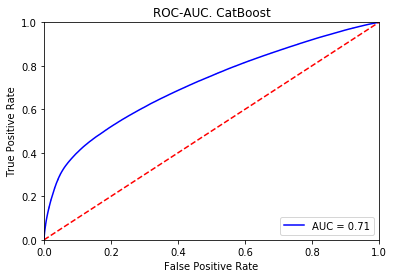

In [78]:
import sklearn.metrics as metrics
probs1 = cat.predict_proba(X_dummy)[:, 1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y, probs1)
roc_auc1 = metrics.auc(fpr1, tpr1)

# method I: plt
import matplotlib.pyplot as plt
plt.title('ROC-AUC. CatBoost')
plt.plot(fpr1, tpr1, 'b', label = 'AUC = %0.2f' % roc_auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Делаем предсказание на тесте и загружаем ответы в файл

In [ ]:
X_test=pd.read_csv('X_test.csv').drop('Unnamed: 0',axis=1).fillna('nan')

In [ ]:
X_test.head()

In [ ]:
probas = log.predict_proba(X_test)[:, 1]
df = pd.DataFrame(probas, columns=['Prob'])
df.to_csv('log_submit.csv', index_label='Id')

In [ ]:
probas = cat.predict_proba(X_test)[:, 1]
df = pd.DataFrame(probas, columns=['Prob'])
df.to_csv('cat_submit.csv', index_label='Id')